**Import packages and read dataset.**

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# df = pd.read_csv('ow2_quickplay_heroes_stats__2023-05-06.csv')
# df = pd.read_csv('ow2_season_01_FINAL_heroes_stats__2023-05-06.csv')
# df = pd.read_csv('ow2_season_02_FINAL_heroes_stats__2023-05-06.csv')
# df = pd.read_csv('ow2_season_03_FINAL_heroes_stats__2023-05-06.csv')
df = pd.read_csv('ow2_season_04_FINAL_heroes_stats__2023-06-27.csv')

**Filter 'Skill Tier' column to 'All' for consistency.**

In [78]:
df_all = df[df['Skill Tier'] == 'All'].copy()

**Print dataset shape, heroes by role to be analyzed, and select key performance metrics/columns for clustering.**

In [79]:
print(f"Dataset shape: {df_all.shape}")
print(f"\nHeroes analyzed: {len(df_all)}")
print(f"\nHeroes by Role:")
print(df_all['Role'].value_counts())

features = [
    'KDA Ratio',
    'Win Rate, %',
    'Eliminations / 10min',
    'Deaths / 10min',
    'Damage / 10min',
    'Healing / 10min',
    'Objective Time / 10min'
]


Dataset shape: (37, 133)

Heroes analyzed: 37

Heroes by Role:
Role
Damage     17
Tank       11
Support     9
Name: count, dtype: int64


**Data Preparation: Fill NaN values with 0 for heroes without healing data.**

In [80]:
X = df_all[features].fillna(0)

**Standardize features and determine inertias for elbow plot to visualize cluster numbers.**

In [81]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertias = []
K_range = range(2, 9)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

**Perform clustering with 3 clusters targeted to Overwatch roles: Tank, Support, DPS.**

In [82]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_all['Cluster'] = kmeans.fit_predict(X_scaled)

**Map clusters to role labels based on role-based characteristics.**

In [83]:
cluster_role_map = {}
for i in range(n_clusters):
    cluster_data = df_all[df_all['Cluster'] == i]
    avg_healing = cluster_data['Healing / 10min'].mean()
    avg_objective_time = cluster_data['Objective Time / 10min'].mean()
    avg_damage = cluster_data['Damage / 10min'].mean()
    
    if avg_healing > 4000:
        cluster_role_map[i] = 'Support'
    elif avg_objective_time > 70:
        cluster_role_map[i] = 'Tank'
    else:
        cluster_role_map[i] = 'Damage'

df_all['Cluster_Role'] = df_all['Cluster'].map(cluster_role_map)

**Apply PCA for visualization.**

In [84]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_all['PCA1'] = X_pca[:, 0]
df_all['PCA2'] = X_pca[:, 1]

**Analyze each cluster with role labels.**

In [85]:
print(f"\n{'='*18}")
print("CLUSTERING RESULTS")
print(f"{'='*18}")

for role in ['Support', 'Tank', 'Damage']:
    cluster_data = df_all[df_all['Cluster_Role'] == role]
    if len(cluster_data) > 0:
        print(f"\n{role.upper()} CLUSTER ({len(cluster_data)} heroes)")
        print(f"Heroes: {', '.join(cluster_data['Hero'].values)}")
        print(f"\nAverage Stats:")
        print(f"  • Win Rate: {cluster_data['Win Rate, %'].mean():.1f}%")
        print(f"  • KDA Ratio: {cluster_data['KDA Ratio'].mean():.2f}")
        print(f"  • Eliminations/10min: {cluster_data['Eliminations / 10min'].mean():.1f}")
        print(f"  • Damage/10min: {cluster_data['Damage / 10min'].mean():.0f}")
        print(f"  • Healing/10min: {cluster_data['Healing / 10min'].mean():.0f}")
        print(f"  • Deaths/10min: {cluster_data['Deaths / 10min'].mean():.1f}")
        print(f"  • Objective Time/10min: {cluster_data['Objective Time / 10min'].mean():.1f}")


CLUSTERING RESULTS

SUPPORT CLUSTER (9 heroes)
Heroes: Ana, Mercy, Kiriko, Moira, Zenyatta, Lucio, Baptiste, Brigitte, Lifeweaver

Average Stats:
  • Win Rate: 48.4%
  • KDA Ratio: 4.64
  • Eliminations/10min: 10.1
  • Damage/10min: 3065
  • Healing/10min: 8300
  • Deaths/10min: 6.4
  • Objective Time/10min: 70.1

TANK CLUSTER (10 heroes)
Heroes: D.Va, Zarya, Roadhog, Sigma, Orisa, Winston, Sombra, Wrecking Ball, Ramattra, Junker Queen

Average Stats:
  • Win Rate: 45.7%
  • KDA Ratio: 4.62
  • Eliminations/10min: 18.7
  • Damage/10min: 8642
  • Healing/10min: nan
  • Deaths/10min: 6.2
  • Objective Time/10min: 112.0

DAMAGE CLUSTER (18 heroes)
Heroes: Genji, Cassidy, Hanzo, Reinhardt, Widowmaker, Soldier: 76, Tracer, Junkrat, Ashe, Reaper, Pharah, Doomfist, Mei, Bastion, Symmetra, Torbjorn, Sojourn, Echo

Average Stats:
  • Win Rate: 48.1%
  • KDA Ratio: 2.92
  • Eliminations/10min: 18.1
  • Damage/10min: 8186
  • Healing/10min: 1299
  • Deaths/10min: 7.9
  • Objective Time/10min: 61

**Create comprehensive visualization for Elbow plot.**

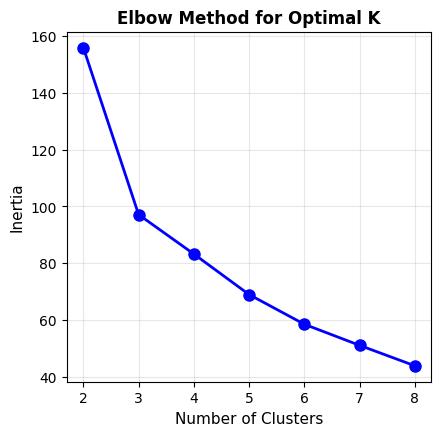

In [86]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters', fontsize=11)
plt.ylabel('Inertia', fontsize=11)
plt.title('Elbow Method for Optimal K', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

**Create comprehensive visualization for PCA scatter plot with role labels.**

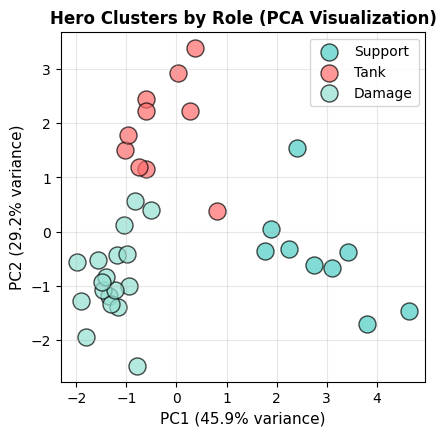

In [87]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 2)
role_colors = {'Support': '#4ECDC4', 'Tank': '#FF6B6B', 'Damage': '#95E1D3'}
for role in ['Support', 'Tank', 'Damage']:
    cluster_data = df_all[df_all['Cluster_Role'] == role]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
                c=role_colors[role], label=role, 
                s=150, alpha=0.7, edgecolors='black', linewidth=1, marker='o')


plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
plt.title('Hero Clusters by Role (PCA Visualization)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

**Create comprehensive visualization for win rate by role.**

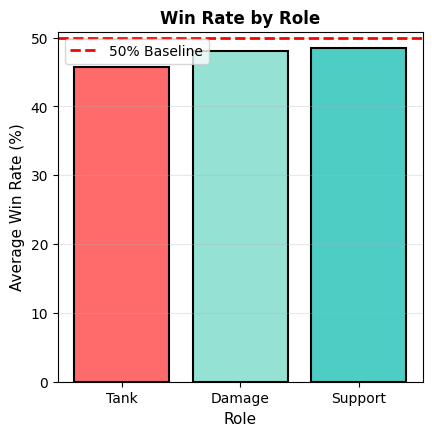

In [88]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 3)
role_winrates = df_all.groupby('Cluster_Role')['Win Rate, %'].mean().reindex(['Tank', 'Damage', 'Support'])
bars = plt.bar(role_winrates.index, role_winrates.values, 
               color=[role_colors[r] for r in role_winrates.index], 
               edgecolor='black', linewidth=1.5)
plt.axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% Baseline')
plt.xlabel('Role', fontsize=11)
plt.ylabel('Average Win Rate (%)', fontsize=11)
plt.title('Win Rate by Role', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

**Create comprehensive visualization for Kill-Death-Assist (KDA) ratio.**

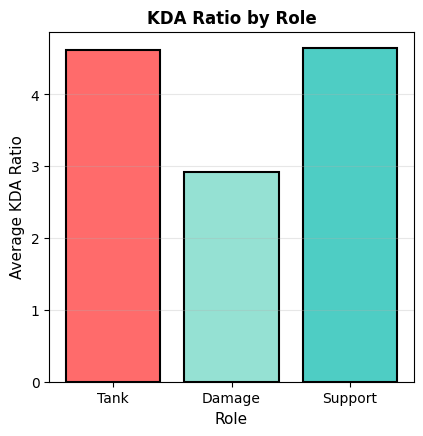

In [89]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 4)
role_kda = df_all.groupby('Cluster_Role')['KDA Ratio'].mean().reindex(['Tank', 'Damage', 'Support'])
plt.bar(role_kda.index, role_kda.values, 
        color=[role_colors[r] for r in role_kda.index], 
        edgecolor='black', linewidth=1.5)
plt.xlabel('Role', fontsize=11)
plt.ylabel('Average KDA Ratio', fontsize=11)
plt.title('KDA Ratio by Role', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

**Create comprehensive visualization for hero count by role.**

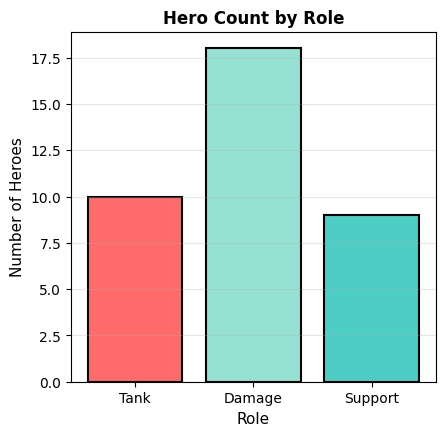

In [90]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 5)
role_counts = df_all['Cluster_Role'].value_counts().reindex(['Tank', 'Damage', 'Support'])
plt.bar(role_counts.index, role_counts.values, 
        color=[role_colors[r] for r in role_counts.index], 
        edgecolor='black', linewidth=1.5)
plt.xlabel('Role', fontsize=11)
plt.ylabel('Number of Heroes', fontsize=11)
plt.title('Hero Count by Role', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')